# Machine learning model for macaque imGCs
#### This prototype-based scoring method is modified from https://github.com/linnarsson-lab/ipynb-lamanno2016 and https://github.com/zhoujoeyyi/humanImmatureNeurons

In [1]:
#%% Import packages ----
from __future__ import division
import pandas as pd
import numpy as np

import os, sys
sys.path.append('./backspinpy-0.2.1/backspinpy/')
from backSPIN import SPIN, backSPIN, feature_selection
from Cef_tools import CEF_obj

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import StratifiedShuffleSplit
from collections import defaultdict
from matplotlib import pyplot as mp
import seaborn as sns
import scipy
from scipy.io import mmread
import pickle
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

np.random.seed(123)

# Prototype-based model training using imGCs of young macaques

In [2]:
#%% Load young monkey hippocampus snRNA-seq dataset and annotate the cell prototypes
# Load data
file = open('database/training_dataset_monkeyYoung.pkl','rb')
df_monkeyYoung = pickle.load(file)
cols_annot_all = pickle.load(file)
file.close()

# Preprocess data, mask blood and mitochondrial genes
blood_genes = ['HBG1','HBA1','HBA2','HBE1']
mito_genes = open('database/MitoGenes.txt').read().split('"\t"')
del mito_genes[0]
del mito_genes[-1]

df_monkeyYoung = df_monkeyYoung.loc[~np.in1d(df_monkeyYoung.index, blood_genes)&\
                   ~np.in1d(df_monkeyYoung.index, mito_genes),:]

df_monkeyYoung = df_monkeyYoung.loc[:,(df_monkeyYoung>0).sum(0)>0]
df_monkeyYoung = df_monkeyYoung.loc[(df_monkeyYoung>0).sum(1)>0,:]

In [3]:
# Annotate the prototypic cells
proto = pd.Series({'nonGCneuron':'none', 'astro':'none', 'granuleCell':'none', 'moli':'none', 'opc':'none', 'microglia':'none', 'nonNeuronalCell':'none', 'x':'none',
                   'proto1_microglia':'proto1_microglia', 'proto2_imgc':'proto2_imgc', 'proto3_moli':'proto3_moli', 'proto4_astro':'proto4_astro', 'proto5_opc':'proto5_opc'})

proto_color = {'proto4_astro': (190,10,10), 'proto1_microglia': (190,10,10), 'proto2_imgc':(255,95,105), 'proto5_opc':(50,180,180),'proto3_moli':(50,180,180)}

ct_monkeyYoung = cols_annot_all[df_monkeyYoung.columns].loc['Cell_type']
proto_group = proto.loc[ct_monkeyYoung].values
df_monkeyYoung = df_monkeyYoung.loc[:,proto_group != 'none']

In [4]:
#%% Enrich for cell type positive markers
df_fall = df_monkeyYoung
cell_types = cols_annot_all[df_fall.columns].loc['Cell_type'].values
df_means = df_fall.mean(1) + 1e-5
df_bin = df_fall>0
df_fold = pd.DataFrame()
df_avgpos = pd.DataFrame()

enrichment_order = ['proto4_astro', 'proto1_microglia', 'proto2_imgc', 'proto3_moli', 'proto5_opc']
for ct in enrichment_order:
    df_fold[ct] = df_fall.loc[:,cell_types == ct].mean(1) / df_means
    df_avgpos[ct] = df_bin.loc[:,cell_types == ct].mean(1)

score00 = df_fold
score05 = df_fold * df_avgpos**0.5
score10 = df_fold * df_avgpos

ix00 = np.argsort( score00 , 0)
ix05 = np.argsort( score05 , 0)
ix10 = np.argsort( score10 , 0)

markers = defaultdict(set)

N = 100

for ct in df_fold.columns:
    markers[ct] |= set( df_fold.index[ix00.loc[:,ct][::-1]][:N] )
    markers[ct] |= set( df_fold.index[ix05.loc[:,ct][::-1]][:N] )
    markers[ct] |= set( df_fold.index[ix10.loc[:,ct][::-1]][:N] )

for ct in df_fold.columns:
    for mk in markers[ct]:
        for ct2 in list( set(df_fold.columns) - set([ct])):
            if score10.loc[mk,ct] >= score10.loc[mk,ct2]:
                markers[ct2] -= set([mk])
    for mk in list(markers[ct]):
        if df_avgpos.loc[mk,ct] < 0.15:
            markers[ct] -= set([mk])

list_genes0 = ([list(markers[ct]) for ct in df_fold.columns])
list_genes = list()
for x in list_genes0:
    for a in x:
        list_genes.append(a)

print(len(list_genes))
df_monkeyYoung = df_monkeyYoung.loc[list(set(list_genes)),:]


547


In [5]:
#%% Train model for monkeyYoung ----
# Prepare dataset for training
df_monkeyYoung_log = np.log2(df_monkeyYoung + 1)
ct_monkeyYoung = cols_annot_all[df_monkeyYoung.columns].loc['Cell_type']
proto_group = proto.loc[ct_monkeyYoung].values
bool1 = proto_group != 'none'
classes_names, classes_index = np.unique(proto_group[bool1], return_inverse=True, return_counts=False)
train_index = classes_index
df_train_set = df_monkeyYoung_log.loc[:,bool1].copy()

#Regularization Path
normalizer = 0.9*df_train_set.values.max(1)[:,np.newaxis]

LR = LogisticRegressionCV(Cs=np.logspace(-8.25,1,30), refit=True, penalty='l2',
                          solver='newton-cg', fit_intercept=False, multi_class='multinomial',class_weight='balanced',
                          cv=StratifiedShuffleSplit(n_splits=35,test_size=0.15, random_state=123))

LR.fit((df_train_set.values/normalizer).T, train_index)

LogisticRegressionCV(Cs=array([5.62341325e-09, 1.17210230e-08, 2.44304257e-08, 5.09209564e-08,
       1.06135842e-07, 2.21221629e-07, 4.61097857e-07, 9.61077966e-07,
       2.00319920e-06, 4.17531894e-06, 8.70272324e-06, 1.81393069e-05,
       3.78082179e-05, 7.88046282e-05, 1.64254487e-04, 3.42359796e-04,
       7.13589212e-04, 1.48735211e-03, 3.10012575e-03, 6.46167079e-03,
       1.34682244e-02, 2.80721620e-02, 5.85115199e-02, 1.21957046e-01,
       2.54198167e-01, 5.29831691e-01, 1.10434164e+00, 2.30180731e+00,
       4.79771541e+00, 1.00000000e+01]),
                     class_weight='balanced',
                     cv=StratifiedShuffleSplit(n_splits=35, random_state=123, test_size=0.15,
            train_size=None),
                     fit_intercept=False, multi_class='multinomial',
                     solver='newton-cg')

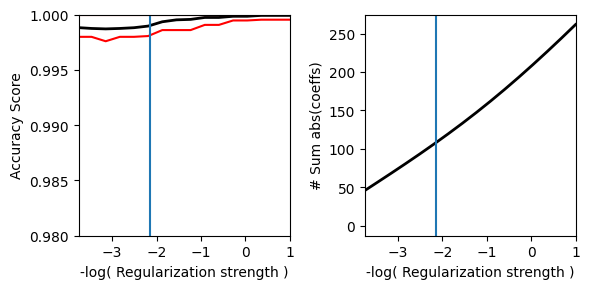

In [6]:
chos = 0.007

# Regularization path plot
mp.figure(figsize=(6,3))
mp.subplot(122)
CMA = np.array([abs(LR.coefs_paths_[i]) for i in range(len(set(classes_index)))])
val_ = np.array( [[sum( sum( CMA[:,i,j,:],0) ,0) for i in range(35)] for j in range(30) ] )
mp.plot( np.log10(LR.Cs_), val_.mean(1), c='k', lw=2 )
mp.xlabel('-log( Regularization strength )')
mp.ylabel('# Sum abs(coeffs)')
mp.xlim(-3.75,1)
mp.axvline( np.log10(chos) )

mp.subplot(121)
mp.plot(np.log10(LR.Cs_), np.mean([LR.scores_[i].mean(0) for i in range(len(set(classes_index)))],0), c='k', lw=2 )
mp.plot(np.log10(LR.Cs_), np.percentile( LR.scores_[1],97.5,0), c='r')
mp.plot(np.log10(LR.Cs_), np.percentile( LR.scores_[1],2.5,0), c='r')
mp.axvline( np.log10(chos) )
mp.ylabel('Accuracy Score')
mp.xlabel('-log( Regularization strength )')
mp.xlim(-3.75,1)
mp.ylim(0.98,1)

mp.tight_layout()
# mp.savefig(r'outputs\RegPath_monkeyYoung.pdf')

In [7]:
#%% Final model (Normalized by the max)

LR = LogisticRegression(C=chos, penalty='l2', solver='newton-cg', fit_intercept=False, 
                        multi_class='multinomial',class_weight='balanced',random_state=123)

normalizer = 0.9*df_train_set.values.max(1)[:,np.newaxis]
LR.fit((df_train_set.values / normalizer).T, train_index)

LogisticRegression(C=0.007, class_weight='balanced', fit_intercept=False,
                   multi_class='multinomial', random_state=123,
                   solver='newton-cg')

<AxesSubplot: >

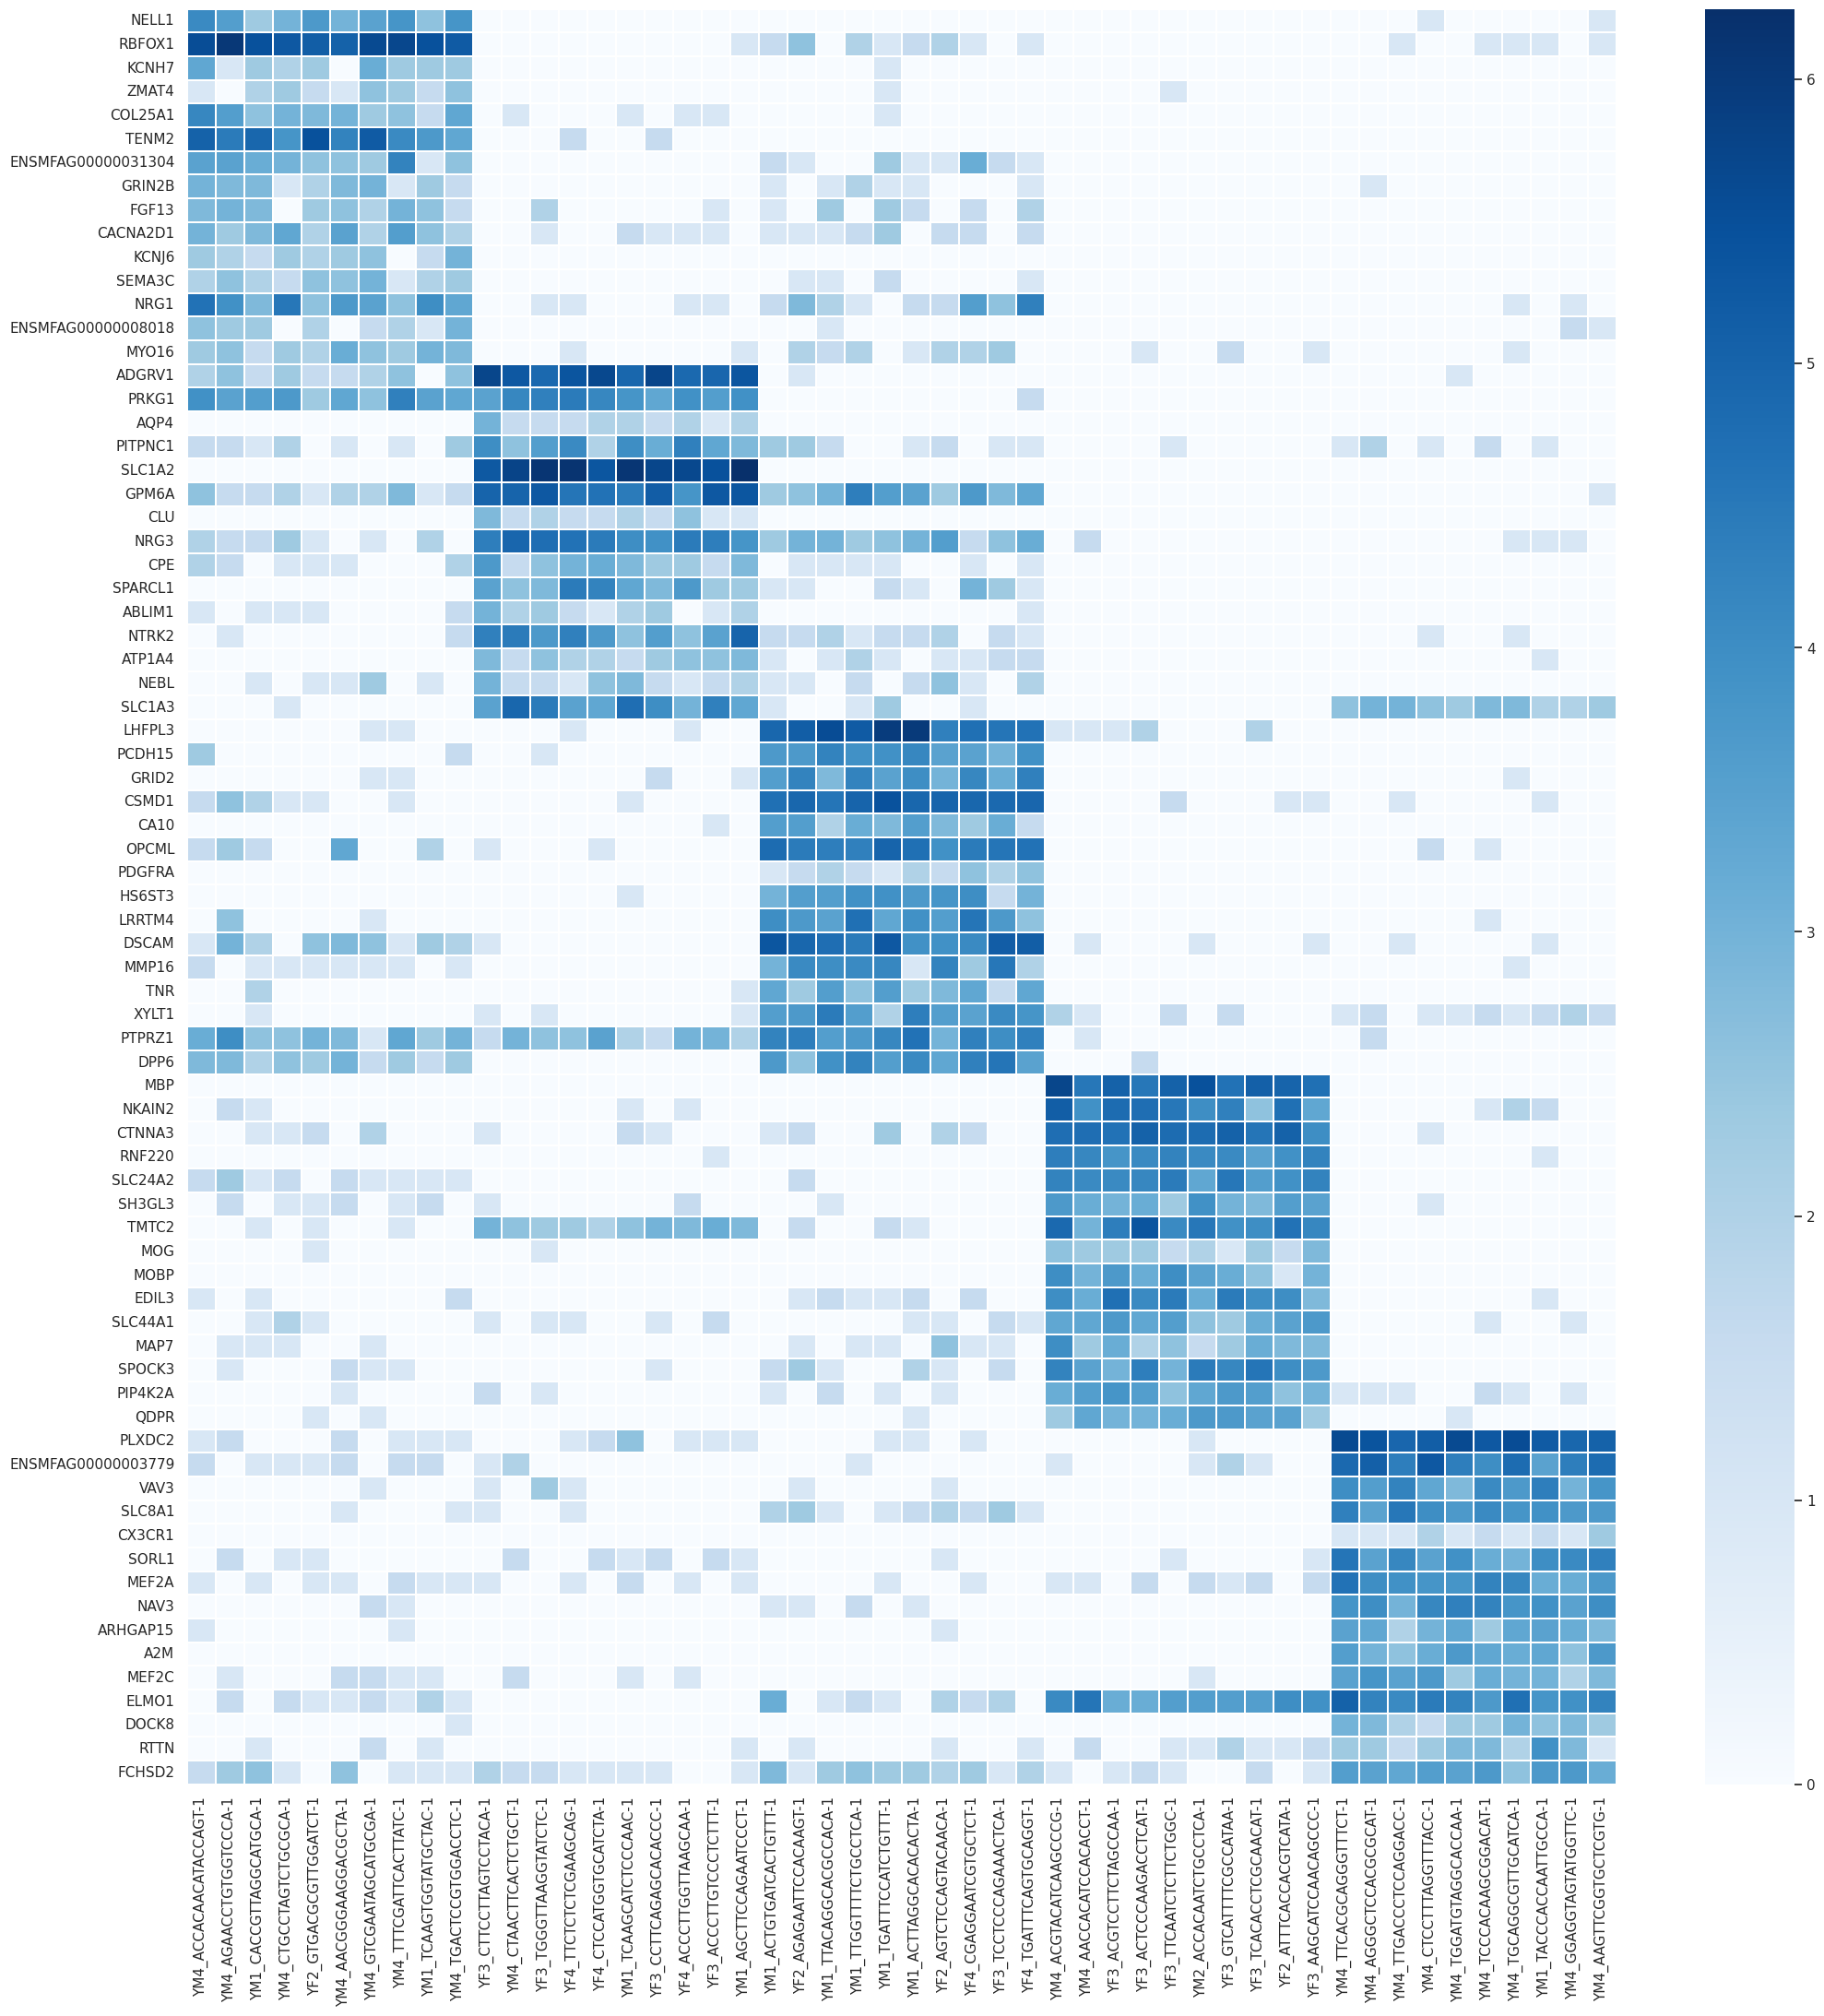

In [8]:
#%% Viualize the top positive weights for each prototype as a heatmap

names_sorted_coef_info = {}
for sel_class in classes_names:
    nonzero_coef_bool = LR.coef_[np.where( classes_names == sel_class )[0][0], :] > 0
    values_nonzero_coef = LR.coef_[ np.where( classes_names == sel_class )[0][0],: ][nonzero_coef_bool]
    names_nonzero_coef= df_monkeyYoung_log.index[nonzero_coef_bool]
    ix_nonzero_coef = np.argsort(values_nonzero_coef)[::-1]
    values_sorted_coef = values_nonzero_coef[ix_nonzero_coef]
    names_sorted_coef = names_nonzero_coef[ix_nonzero_coef]
    names_sorted_coef_info[sel_class] = list(names_sorted_coef)

# Predict cell scores and pick top cells
res = LR.predict_proba((df_train_set.values / normalizer).T)
hist_order = enrichment_order
hist_ixes = [list(classes_names).index(i) for i in hist_order]
resdf = pd.DataFrame(res)
resdf.columns = classes_names
resdf.index = df_train_set.columns

# Make a heatmap

reorder = ['proto2_imgc', 'proto4_astro', 'proto5_opc', 'proto3_moli', 'proto1_microglia']

cell_thrs = 10
gene_thrs = 15
reorder_celllist = []
reorder_genelist = []
for sel_class in reorder:
    reorder_celllist += resdf.sort_values(sel_class, ascending=False)[:cell_thrs].index.tolist()
    reorder_genelist += names_sorted_coef_info[sel_class][:gene_thrs]
    
topcellsheatmap = df_train_set.loc[reorder_genelist, reorder_celllist]

mp.rcParams['savefig.dpi'] = 100
mp.figure(figsize=(25,25))
sns.set(font_scale=1)
sns.heatmap(topcellsheatmap, cmap = 'Blues', linewidths = 0.2, annot=False)
# mp.savefig('outputs\TopWeightHeatmap_monkeyYoung.pdf')

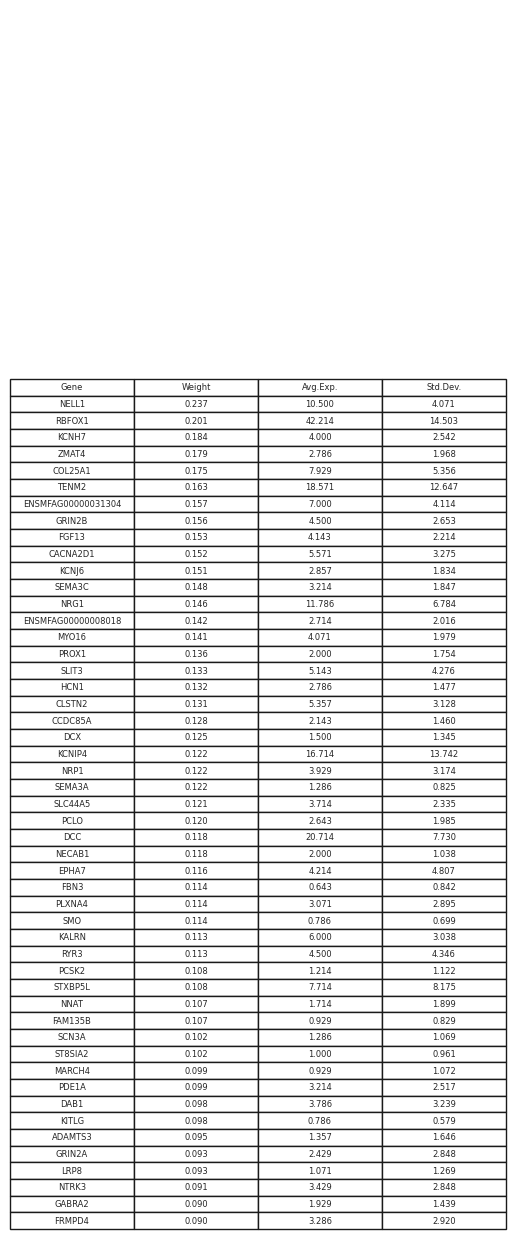

In [9]:
#%% Viualize the top 50 positive weights defining young monkey immature neurons
sel_class = 'proto2_imgc'
nonzero_coef_bool = LR.coef_[ np.where( classes_names == sel_class )[0][0],: ]
values_nonzero_coef = LR.coef_[ np.where( classes_names == sel_class )[0][0],: ]
names_nonzero_coef= df_monkeyYoung_log.index
ix_nonzero_coef = np.argsort(values_nonzero_coef)[::-1]
values_sorted_coef = values_nonzero_coef[ix_nonzero_coef]
names_sorted_coef = names_nonzero_coef[ix_nonzero_coef]

avg_expr = df_monkeyYoung.loc[names_sorted_coef, proto_group == sel_class].mean(1)
std_expr = df_monkeyYoung.loc[names_sorted_coef, proto_group == sel_class].std(1)

# Plot in a matplotlib table
mp.rcParams['savefig.dpi'] = 300
colLabels=("Gene", "Weight", 'Avg.Exp.', 'Std.Dev.')
rows_list = zip(list(names_sorted_coef)[:50],\
                list(map(lambda x: '%.3f' % x, values_sorted_coef[:50])),\
                list(map(lambda x: '%.3f' % x, avg_expr[:50])),\
                list(map(lambda x: '%.3f' % x, std_expr[:50])))
rows_list = list(rows_list)
nrows, ncols = len(rows_list)+1, len(colLabels)
hcell, wcell = 0.02, 0.7
hpad, wpad = 0, 0
fig = mp.figure()
ax = fig.add_subplot(111)
ax.axis('off')
the_table = ax.table(cellText=rows_list, colLabels=colLabels, cellLoc='center')


# Identify imGCs from test datasets

## Apply test set (using Wang et al. Cell Research 2022 dataset as an example)

In [10]:
counts = pd.read_csv('database/Wang/counts.csv', index_col=0)
md = pd.read_csv('database/Wang/metadata.csv', index_col=0).T

In [ ]:
df_dev = counts.copy()
df_dev = df_dev.reindex(list(set(list_genes)))

# Load into the trained model ----
# Log normalization
df_dev_log = np.log2(df_dev + 1)

df_train_set = df_dev_log.loc[:,:].copy() 
print(df_train_set.shape)

normalizer = 0.9*df_train_set.values.max(1)[:,np.newaxis]

unseen = (df_train_set.values / normalizer).T

where_nan = np.isnan(unseen)
unseen[where_nan] = 0

#check on NaN and infinity, for it to pass the test, it should be: false, then true
print(np.any(np.isnan(unseen)))
print(np.all(np.isfinite(unseen)))


# Export to Seurat scoring plot
ScoringPlot = LR.predict_proba(unseen)
ScoringPlot = pd.DataFrame(ScoringPlot)
ScoringPlot.columns = classes_names
ScoringPlot.index = df_train_set.columns
ScoringPlot.to_csv('output/ExportToSeuratScoringPlot_xqwhipmky4yr.csv', header = True)